In [1]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.nn.functional as F

from src6.CNN import CNNActionValue
from src6.evaluate import evaluate
import src6.DQN as DQN
from src6.Preprocess import preprocess, ImageEnv

In [2]:
import os  # os 모듈 추가
import torch

# 체크포인트 저장 함수
def save_checkpoint(agent, optimizer, step, filename='./model_checkpoint.pth'):
    print(f'{step}번째 스텝에서 체크포인트 저장 중...')
    torch.save({
        'step': step,
        'model_state_dict': agent.network.state_dict(),  # DQN 전체가 아닌 내부 네트워크만 저장
        'optimizer_state_dict': optimizer.state_dict(),
    }, filename)


# 체크포인트 불러오기 함수
def load_checkpoint(agent, optimizer, filename='./model_checkpoint.pth'):
    if os.path.isfile(filename):
        print(f'{filename}에서 체크포인트 불러오는 중...')
        checkpoint = torch.load(filename)

        agent.network.load_state_dict(checkpoint['model_state_dict'])  # 핵심 수정
        agent.target_network.load_state_dict(agent.network.state_dict())  # 타겟 네트워크도 맞춰줌
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        step = checkpoint['step']
        print(f'체크포인트 불러오기 완료, {step}번 스텝부터 이어서 학습 시작')
        return agent, optimizer, step
    else:
        print('체크포인트를 찾을 수 없습니다. 새로 시작합니다.')
        return agent, optimizer, 0





Observation space:  Box(0, 255, (96, 96, 3), uint8)
Action space:  Discrete(5)
(96, 96, 3)


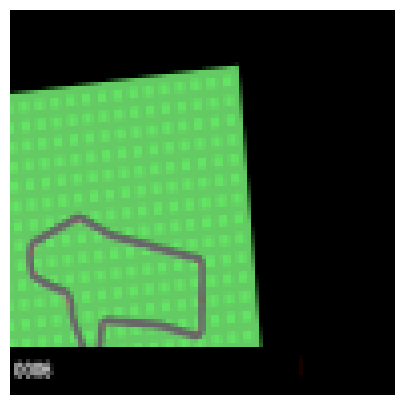

In [3]:
# 환경 생성
env = gym.make('CarRacing-v3', continuous=False)
print("Observation space: ", env.observation_space)
print("Action space: ", env.action_space)

# 초기 상태 확인
s, info = env.reset()
print(s.shape)

# 애니메이션을 위한 프레임 수집
frames = []
for i in range(50):
    s, r, terminated, truncated, info = env.step(0)  # 0-th action is no_op action
    frames.append(s)

# 애니메이션 생성
fig = plt.figure(figsize=(5, 5))
plt.axis('off')
im = plt.imshow(frames[0])
def animate(i):
    im.set_array(frames[i])
    return im,
anim = FuncAnimation(fig, animate, frames=len(frames))
HTML(anim.to_jshtml())


The shape of an observation:  (4, 84, 84)


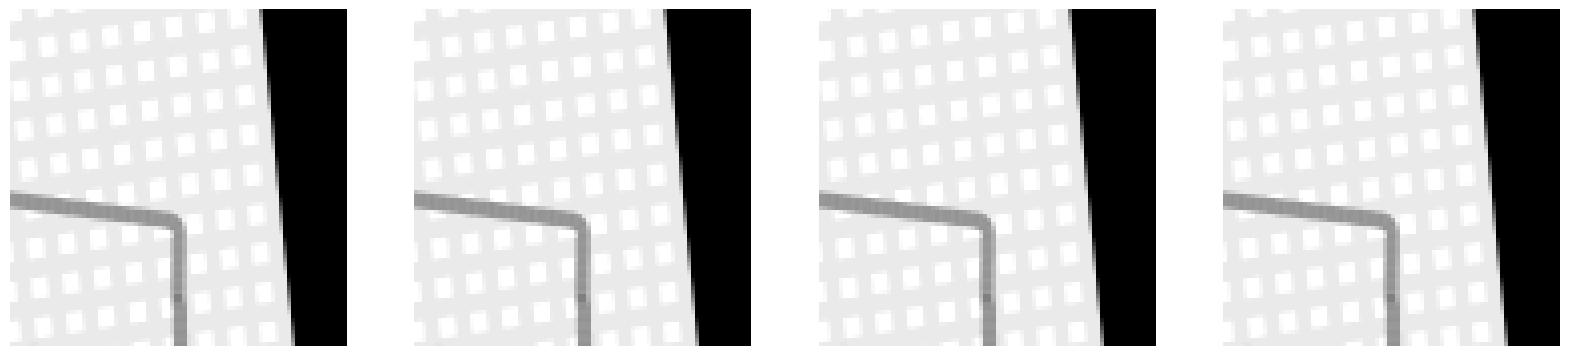

In [4]:
# 환경 전처리 (ImageEnv로 래핑)
env = gym.make('CarRacing-v3', continuous=False)
env = ImageEnv(env)

# 초기 상태 및 시각화
s, _ = env.reset()
print("The shape of an observation: ", s.shape)

# 여러 이미지 시각화
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    axes[i].imshow(s[i], cmap='gray')
    axes[i].axis('off')
plt.show()


In [5]:
max_steps = int(1e4)
eval_interval = 100
state_dim = (4, 84, 84)
action_dim = env.action_space.n
agent = DQN.DQN(state_dim, action_dim)
optimizer = torch.optim.Adam(agent.network.parameters(), lr=1e-4)

# 체크포인트 불러오기 (기존 학습이 있으면 불러와서 이어서 학습)
agent, optimizer, step = load_checkpoint(agent, optimizer)

./model_checkpoint.pth에서 체크포인트 불러오는 중...
체크포인트 불러오기 완료, 10001번 스텝부터 이어서 학습 시작


In [6]:
def evaluate(n_evals=5):
    eval_env = gym.make('CarRacing-v3', continuous=False)
    eval_env = ImageEnv(eval_env)
    
    scores = 0
    for i in range(n_evals):
        (s, _), done, ret = eval_env.reset(), False, 0
        while not done:
            a = agent.act(s, training=False)
            s_prime, r, terminated, truncated, info = eval_env.step(a)
            s = s_prime
            ret += r
            done = terminated or truncated
        scores += ret
    return np.round(scores / n_evals, 4)

In [7]:
import os

# 체크포인트 저장 함수
def save_checkpoint(model, optimizer, step, filename='./model_checkpoint.pth'):
    print(f'{step}번째 스텝에서 체크포인트 저장 중...')
    torch.save({
        'step': step,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, filename)

# 체크포인트 불러오기 함수
def load_checkpoint(model, optimizer, filename='./model_checkpoint.pth'):
    if os.path.isfile(filename):
        print(f'{filename}에서 체크포인트 불러오는 중...')
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        step = checkpoint['step']
        print(f'체크포인트 불러오기 완료, {step}번 스텝부터 이어서 학습 시작')
        return model, optimizer, step
    else:
        print('체크포인트를 찾을 수 없습니다. 새로 시작합니다.')
        return model, optimizer, 0  # 체크포인트가 없으면 0번 스텝부터 시작


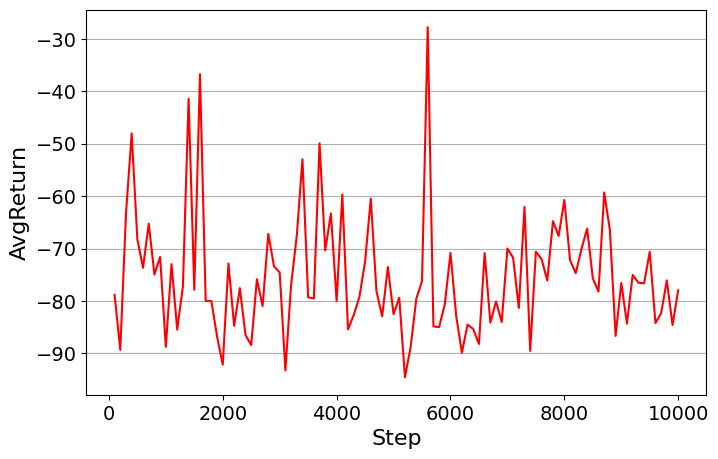

10001번째 스텝에서 체크포인트 저장 중...


In [8]:
from IPython.display import clear_output

# 학습 히스토리
history = {'Step': [], 'AvgReturn': []}

# 환경 초기화 및 학습 루프
(s, _) = env.reset()
while True:
    # 에이전트 행동 선택 및 상태 업데이트
    a = agent.act(s)
    s_prime, r, terminated, truncated, info = env.step(a)
    result = agent.process((s, a, r, s_prime, terminated))  # 트래킹하는 부분
    
    s = s_prime
    if terminated or truncated:
        s, _ = env.reset()
        
    # 일정 스텝마다 평가 및 모델 저장
    if agent.total_steps % eval_interval == 0:
        ret = evaluate()
        history['Step'].append(agent.total_steps)
        history['AvgReturn'].append(ret)
        
        clear_output()
        plt.figure(figsize=(8, 5))
        plt.plot(history['Step'], history['AvgReturn'], 'r-')
        plt.xlabel('Step', fontsize=16)
        plt.ylabel('AvgReturn', fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.grid(axis='y')
        plt.savefig("AvgReturn_result6_01.jpg", dpi=300, bbox_inches='tight')
        plt.show()
        
    
    if agent.total_steps > max_steps:
        break

# 마지막 체크포인트 저장
save_checkpoint(agent.network, optimizer, agent.total_steps)


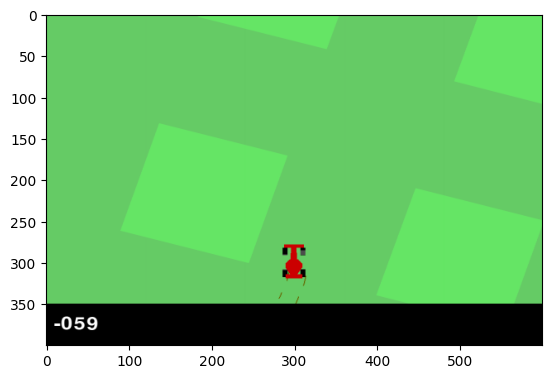

In [9]:
# 평가 및 애니메이션 생성
eval_env = gym.make('CarRacing-v3', continuous=False, render_mode='rgb_array')
eval_env = ImageEnv(eval_env)

frames = []
scores = 0
(s, _), done, ret = eval_env.reset(), False, 0
while not done:
    frames.append(eval_env.render())
    a = agent.act(s, training=False)
    s_prime, r, terminated, truncated, info = eval_env.step(a)
    s = s_prime
    ret += r
    done = terminated or truncated
scores += ret

import matplotlib.animation as animation
fig = plt.figure()
ims = []

for frame in frames:
    im = plt.imshow(frame, animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True)

# 애니메이션 저장
ani.save('car_racing_result6_1.gif', writer='pillow')

plt.show()
